In [7]:
import pandas as pd
import pickle as pkl
import os


def get_target_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['diagnosis_anns']
            anns = {(k, question): v2 for k, v in anns.items() for question, v2 in v.items()}
            del instance_data['diagnosis_anns']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()


In [8]:
df = get_target_df('/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/target_annotations/val2/Andrea/')
df

,instance_idx,split,"(pulmonary edema, report_idx)","(pulmonary edema, is_confident_diagnosis)","(pulmonary edema, could_be_identified_earlier)","(pneumonia, report_idx)","(pneumonia, is_confident_diagnosis)","(pneumonia, could_be_identified_earlier)","(cancer, report_idx)","(cancer, is_confident_diagnosis)","(cancer, could_be_identified_earlier)"
0,49,val2,35,Yes,No,57,Yes,Yes,NaN,NaN,NaN
1,51,val2,4,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
2,53,val2,3,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
3,54,val2,NaN,NaN,NaN,NaN,NaN,NaN,24,Yes,Yes
4,58,val2,7,No,NaN,7,No,NaN,NaN,NaN,NaN
5,62,val2,31,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,66,val2,31,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
7,71,val2,6,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
8,74,val2,NaN,NaN,NaN,NaN,NaN,NaN,6,Yes,Yes
9,76,val2,NaN,NaN,NaN,14,Yes,Yes,8,Yes,Yes


<Axes: xlabel='condition'>

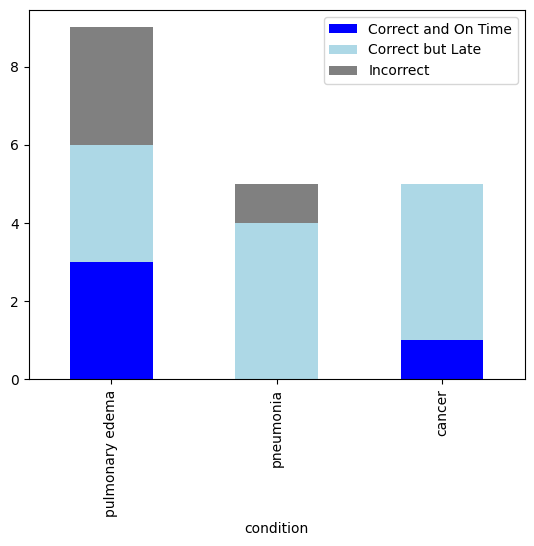

In [30]:
import seaborn as sns
from collections import Counter
row = []
for condition in ['pulmonary edema', 'pneumonia', 'cancer']:
    y = df[~df[(condition, 'is_confident_diagnosis')].isna()].apply(lambda r:
        'Incorrect' if r[(condition, 'is_confident_diagnosis')] == 'No' else \
        'Correct and On Time' if r[(condition, 'could_be_identified_earlier')] == 'No' else \
        'Correct but Late', axis=1)
    y = Counter(y)
    row.append({
        'condition': condition,
    })
    row[-1].update(y)
pd.DataFrame(row).set_index('condition').plot(kind='bar', stacked=True, color=['blue', 'lightblue', 'grey'])

